<h2 align="center">Round 5 - Clustering.</h2>

<br>
<br>
<center>CS-EJ3211 Machine Learning with Python 10.01.-08.04.2022</center>
<center>Aalto University (Espoo, Finland)</center>
<center>fitech.io (Finland)</center>

In this round, you will learn how to group a set of data points (e.g. representing customers of a cafe) into coherent groups (**clusters** or segments) using **clustering methods**.  Clustering methods group collections of data points into a number of groups or clusters based on the features of the data points. The idea is that data points within the same cluster are more similar to each other than to the data points outside the cluster. In this notebook, you will familiarize yourself with, as well as apply, the hard clustering method **k-means** and a soft clustering method based on a probabilistic **Gaussian mixture model** (GMM).

Different clustering methods use different notions of similarity between data points. A common measure of similarity for data points with real-valued features is the Euclidean distance (or $\ell_2$-norm), which is a generalization of our intuitive notion of distance in 2d- and 3d-space to vectors with $n$ elements. This measure of similarity is utilized by the k-means clustering algorithm presented in this notebook.

In some applications, it is beneficial to use a different concept of similarity which is not directly tied to the Euclidean distance. Hence, we will also consider the clustering method [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) which uses a "non-Euclidean" notion of similarity between data points.


## Learning goals 

After this round, you should  

- be able to use k-means for hard clustering of a data set. 
- be able to use GMM for soft clustering of a data set. 
- be able to use DBSCAN for hard clustering of data points having a non-Euclidean structure. 
- be able to choose between different clustering methods. 

## Reading Material 

* Chapter Chapter 8 of course book [Machine Learning: The basics.](https://github.com/alexjungaalto/MachineLearningTheBasics/blob/master/MLBasicsBook.pdf)  


## Additional Material 

* Prof. A. Ng explaining [hard-clustering via k-Means](https://www.youtube.com/watch?v=hDmNF9JG3lo)
* Prof. A. Ihler on [soft-clustering with Gaussian mixture models](https://www.youtube.com/watch?v=qMTuMa86NzU)
* scikit-learn page on [k-means](https://scikit-learn.org/stable/modules/clustering.html#k-means)
* scikit-learn page on [Gaussian mixture models](https://scikit-learn.org/stable/modules/mixture.html#mixture)
* scikit-learn page on [DBSCAN](https://scikit-learn.org/stable/modules/clustering.html#dbscan)

##  Introduction

Clustering methods partition a dataset consisting of $m$ data points $\mathbf{x}^{(i)} \in \mathbb{R}^{n}$, into a small number of groups or "clusters" $\mathcal{C}_{1},\ldots,\mathcal{C}_{k}$. Each cluster $\mathcal{C}_{l}$ represents a subset of data points which are more similar to each other than to data points in another cluster. The precise meaning of two data points being "similar" depends on the application at hand. 

Clustering methods do not require labeled data and can be applied to data points characterized solely by its features $\mathbf{x}^{(i)}$. Therefore, clustering methods are an example of **unsupervised machine learning methods**. However, clustering methods are also used in combination (e.g., as a preprocessing step) with supervised learning methods such as regression or classification. 

Clustering methods are roughly divided into two groups:

* Hard clustering methods that assign each data point to exactly one cluster and 
* Soft clustering methods that assign each data point to several different clusters with varying degrees of belonging.

Hard clustering can be interpreted as a special case of soft-clustering where the degrees of belonging are enforced to be either 0 (not belonging) or 1 (belongs). 

This notebook will consider one popular method for hard clustering, the k-means algorithm, and one popular method for soft clustering based on a probabilistic Gaussian mixture model (GMM). These two methods use a notion of similarity that is tied to the Euclidean geometry of $\mathbb{R}^{n}$. 

The notebook also presents the DBSCAN algorithm, which is a hard clustering method that uses a non-Euclidean notion of similarity to cluster the data points. 

## The Data

Suppose that we are running a Cafe in Helsinki and want to explore whether there are distinct customer segments in our clientele, in order to find the best marketing strategy for the next summer. To this end, we will use clustering methods.

The file "data.csv" contains $m=400$ rows representing the data points $\mathbf{x}^{(i)}=
\big( x_{1}^{(i)},x_{2}^{(i)} \big)$, for $i=1,\ldots,m$. The first column of the $i$-th row in the file contains the age $x_{1}^{(i)}$ of the $i$-th customer. The second column contains the amount $x_{2}^{(i)}$ of money spent by the $i$-th customer.

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Loading the Data. 
 
The following code loads the dataset into a pandas dataframe and converts it into a numpy matrix $\mathbf{X}$, in which each row represents a data point and each column a feature.

The data is then plotted in a scatter plot using the custom helper function `plotting` for plotting a scatter plot of a dataset with or without clusters.
</div>

In [59]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

# Read in data from the csv file and store it in the data matrix X.
df = pd.read_csv("../../../coursedata/R5_Clustering/data.csv")
X = df.to_numpy()

# Display first 5 rows
print("First five datapoints:")
display(df.head(5))  

First five datapoints:


,Age,Spending
0,28.018868,5.263333
1,27.897623,5.276452
2,29.042011,4.794357
3,29.669165,5.207227
4,29.494291,6.351539


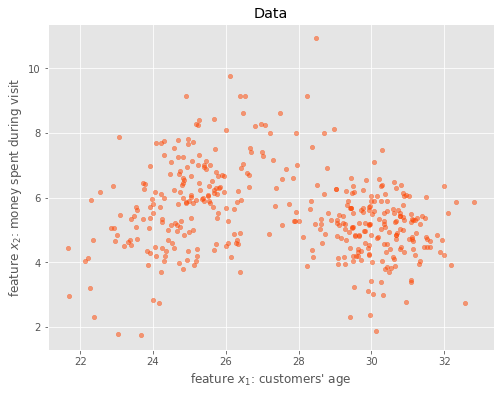

In [60]:
def plotting(data, centroids=None, clusters=None, title='Data', show=True):
    # This function will later on be used for plotting the clusters and centroids. But now we use it to just make a scatter plot of the data
    # Input: the data as an array, cluster means (centroids), cluster assignemnts in {0,1,...,k-1}   
    # Output: a scatter plot of the data in the clusters with cluster means
    plt.figure(figsize=(8,6))
    data_colors = ['orangered', 'dodgerblue', 'springgreen']
    centroid_colors = ['red', 'darkblue', 'limegreen'] # Colors for the centroids
    plt.style.use('ggplot')
    plt.title(title)
    plt.xlabel("feature $x_1$: customers' age")
    plt.ylabel("feature $x_2$: money spent during visit")

    alp = 0.5             # data points alpha
    dt_sz = 20            # marker size for data points 
    cent_sz = 130         # centroid sz 
    
    if centroids is None and clusters is None:
        plt.scatter(data[:,0], data[:,1], s=dt_sz, alpha=alp, c=data_colors[0])
    if centroids is not None and clusters is None:
        plt.scatter(data[:,0], data[:,1], s=dt_sz, alpha=alp, c=data_colors[0])
        plt.scatter(centroids[:,0], centroids[:,1], marker="x", s=cent_sz, c=centroid_colors[:len(centroids)])
    if centroids is not None and clusters is not None:
        plt.scatter(data[:,0], data[:,1], c=[data_colors[i] for i in clusters], s=dt_sz, alpha=alp)
        plt.scatter(centroids[:,0], centroids[:,1], marker="x", c=centroid_colors[:len(centroids)], s=cent_sz)
    if centroids is None and clusters is not None:
        plt.scatter(data[:,0], data[:,1], c=[data_colors[i] for i in clusters], s=dt_sz, alpha=alp)
    
    if show:
        plt.show()

# Plot the (unclustered) data
plotting(X)   

# Hard Clustering

Hard clustering partitions a dataset $\mathbf{X}$ into $k$ clusters $\mathcal{C}_1,\ldots,\mathcal{C}_k$, so that each data point is assigned to precisely one cluster. We denote by $y^{(i)} \in \{1,\ldots,k\}$ the index of the cluster to which the $i$th data point $\mathbf{x}^{(i)}$ is assigned. 

The formal setup of hard clustering is quite similar to that of classification methods. We can interpret the cluster index $y^{(i)}$ as the label (quantity of interest) associated with the $i$:th data point. However, in contrast to classification, $y^{(i)}$ is not known in advance and is instead inferred from the similarities between data points.

Clustering methods do not require knowledge of the **true cluster assignment** for any data point. Instead, clustering methods learn a reasonable cluster assignment for a data point based on the intrinsic geometry of the entire dataset $\mathbb{X}$. Clustering methods are an example of **unsupervised machine learning** methods since they do not need labeled data. 



## The k-Means Algorithm

A popular method for hard clustering is the k-means algorithm, which clusters the data into $k$ clusters by alternately calculating the coordinates for the cluster means and updating the cluster assignments to minimize the sum of squared distances of the data points and their respective cluster means. Let us consider this idea in more detail.

Each (non-empty) cluster $\mathcal{C}_{c} \subseteq \mathbb{X}$ is characterized by the cluster mean 

\begin{equation*}
\mathbf{m}^{(c)} = (1/|\mathcal{C}_{c}|) \sum_{\mathbf{x}^{(i)} \in \mathcal{C}_{c}} x^{(i)}, 
\end{equation*}

where $|\mathcal{C}_c|$ denotes the number of data points in the cluster $C_c$.

If we would know the cluster means $\mathbf{m}^{(c)}$ for each cluster, we could assign each data point $\mathbf{x}^{(i)}$ to the cluster with index $y^{(i)}$ whose mean is closest to $\mathbf{x}^{(i)}$: 

\begin{equation}
\| \mathbf{x}^{(i)} - \mathbf{m}^{y^{(i)}} \| = {\rm min}_{c \in \{1,\ldots,k\}}\| \mathbf{x}^{(i)} - \mathbf{m}^{(c)} \|. 
\end{equation} 

However, in order to determine the cluster means $\mathbf{m}^{(c)}$, we would have needed the cluster assignments $y^{(i)}$ already in the first place. This instance of an [egg-chicken dilemma](https://en.wikipedia.org/wiki/Chicken_or_the_egg) is resolved by the $k$-means algorithm as follows:

### Algorithm: k-means clustering

* __Input__: data points $\mathbf{x}^{(i)} \in \mathbb{R}^{n}$, for $i=1,\ldots,m$ and number $k$ of clusters


* __Initialization__: choose initial cluster means $\mathbf{m}^{(1)},\ldots,\mathbf{m}^{(k)} \in \mathbb{R}^{n}$. This can be done deterministically, randomly, or by smart methods that result in better initial means than purely random initialization.


* __Repeat Until Stopping Condition is Met:__  

    * __Update Cluster Assignments__: assign each data to the nearest cluster: 
    
    for each data point $i=1,\ldots,m$, set  
    
    \begin{equation*}
    y^{(i)} = \underset{c' \in \{1,\ldots,k\}}{\operatorname{argmin}} \|\mathbf{x}^{(i)} - \mathbf{m}^{(c')}\|^2 , 
    \tag{1}
    \end{equation*}
    
    * __Update Cluster Means__: determine cluster means for new cluster assignments 
    
    for each cluster $c=1,\ldots,k$, set 
    \begin{equation*}
    \mathbf{m}^{(c)} = \frac{1}{\mid\{i: y^{(i)}= c\}\mid}{\sum_{i: y^{(i)}= c}\mathbf{x}^{(i)}}     
    \label{mean}
    \tag{2}
    \end{equation*}
    where $\{i: y^{(i)}= c\}$ represents the set of datapoints belonging to cluster c and $\mid\{i: y^{(i)}= c\}\mid$ the size of cluster c.  
    


The $k$-means algorithm is best understood by walking through an example. To this end, we apply the $k$-means algorithm to the customer data discussed above.

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Apply k-means. 

The code snippet below uses the `KMeans()` class in scikit-learn to group the Cafe customers into $k=3$ clusters $\mathcal{C}_{1}$,$\mathcal{C}_{2}$ and $\mathcal{C}_{3}$ using k-means. We hypothesize that these clusters represent three different customer segments. 
    
The resulting clusters are depicted in a scatter plot with distinct colors for the different clusters. The cluster means (centers) $\mathbf{m}^{(1)}$, $\mathbf{m}^{(2)}$ and $\mathbf{m}^{(3)}$ are represented by crosses.   

 </div>

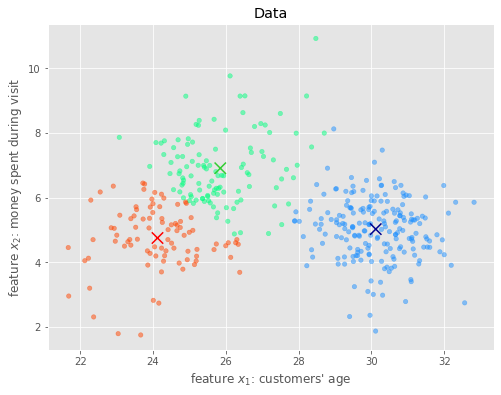

In [61]:
from sklearn.cluster import KMeans

m, n = X.shape    # Get the number of data points m and number of features n

k = 3    # Define number of clusters to use

k_means = KMeans(n_clusters = k, max_iter = 100)  # Create k-means object with k=3 clusters and using maximum 100 iterations
k_means.fit(X)    # Fit the k-means object (find the cluster labels for the datapoints in X)
cluster_means = k_means.cluster_centers_    # Get cluster means (centers)
cluster_indices = k_means.labels_           # Get the cluster labels for each data point

# Plot the clustered data
plotting(X, cluster_means, cluster_indices)

<a id='handsondata'></a>
<div class=" alert alert-warning">
    <b>Student Task.</b> Apply k-means. 
 

Apply the k-means algorithm on the customer data in the matrix `X` using the `scikit-learn` class `KMeans`. The class allows specifying the number of clusters and number of iterations with the input parameters `n_clusters` and `max_iter`. Use `max_iter=10` so that the function alternatingly updates the cluster assignment and cluster means $10$ times. Apply k-means with $k=2$ clusters. Do not set any other input parameter so that their default values are used. 

Store the resulting cluster means in the numpy array `cluster_means` of shape (2,2) and the resulting cluster assignments in the numpy array `cluster_indices` of shape (400, ). 

[Documentation of k-means in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

 </div>

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1]


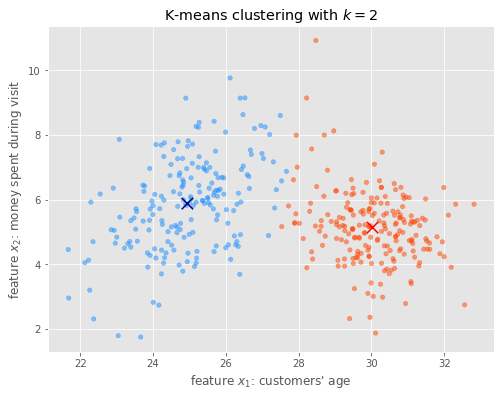

The final cluster mean values are:
 [[30.03164456  5.13271688]
 [24.94326652  5.87406858]]


In [62]:
from sklearn.cluster import KMeans

m, n = X.shape    # Get the number of data points m and number of features n

k = 2    # The number of clusters to use

np.random.seed(1)    # Set random seed for reproducability (DO NOT CHANGE THIS!)

'''
k = 3    # Define number of clusters to use

k_means = KMeans(n_clusters = k, max_iter = 100)  # Create k-means object with k=3 clusters and using maximum 100 iterations
k_means.fit(X)    # Fit the k-means object (find the cluster labels for the datapoints in X)
cluster_means = k_means.cluster_centers_    # Get cluster means (centers)
cluster_indices = k_means.labels_           # Get the cluster labels for each data point
'''
### STUDENT TASK ###
# ...
k_means = KMeans(n_clusters = k, max_iter = 10)
k_means.fit(X)
cluster_means = k_means.cluster_centers_
cluster_indices = k_means.labels_   
print(cluster_indices)
# YOUR CODE HERE

# Plot the clustered data
plotting(X, cluster_means, cluster_indices, title='K-means clustering with $k=2$')
print("The final cluster mean values are:\n", cluster_means)

In [63]:
# Perform some sanity checks on the outputs
assert X.shape == (400, 2), f'numpy array X has wrong shape'
assert cluster_means.shape == (2, 2), f'numpy array cluster_means has wrong shape'
assert cluster_indices.shape == (400,), f'numpy array cluster indices has wrong shape'

print('Sanity check tests passed!')

Sanity check tests passed!


In [64]:
# hidden tests


If you have completed the task correctly, you should see plot similar to this one:

<img src="../../../coursedata/R5_Clustering/Apply_kmeans.png" alt="Drawing" style="width: 600px;"/>

## Handling Local Minima

The k-means algorithm can be interpreted as a method for minimizing the **clustering error**

\begin{equation}
\mathcal{E}  \big( \{\mathbf{m}^{(c)}\}_{c=1}^{k},\{y^{(i)}\}_{i=1}^{m} \mid \{\mathbf{x}^{(i)}\}_{i=1}^{m} \big)
= \sum_{i=1}^{m} {\left\|\mathbf{x}^{(i)}-\mathbf{m}^{(y^{(i)})}\right\|^2}, 
\label{EqErr}
\tag{3}
\end{equation}

which is the mean squared distance between each data point $\mathbf{x}^{(i)}$ and the mean $\mathbf{m}^{(y^{(i)})}$ of its assigned cluster. 

On each iteration, the k-means algorithm first minimizes the clustering error with respect to the cluster assignments $\{y^{(i)}\}_{i=1}^{m}$ given the current means $\mathbf{m}^{(y^{(i)})}$. Next, the algorithm minimizes the clustering error with respect to the cluster means $\mathbf{m}^{(y^{(i)})}$ given the newly assigned clusters. By repeating this alternating minimization, the k-means algorithm moves towards progressively better clusterings with lower clustering errors.

The optimization interpretation of k-means allows us to define a criterion for stopping the cluster assignment and means updates. The input parameter `tol` of the Python function `KMeans` allows us to specify a relative value of objective decrease that is used to define convergence (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)).

Since the clustering error is a [non-convex function](https://stats.stackexchange.com/questions/324561/difference-between-convex-and-concave-functions) of the cluster means and assignments, the k-means method might get trapped in a [**local minimum**](https://en.wikipedia.org/wiki/Maxima_and_minima#/media/File:Extrema_example_original.svg). This means that the k-means algorithm terminates before finding the best possible clustering, as measured by the clustering error. 

In particular, the initial cluster means significantly affect the final clustering of the k-means algorithm. For some selections of initial means, the best possible clustering might be unobtainable. Thus, it is useful to repeat k-means **several times with different initializations** for the cluster means, and select the cluster assignment resulting in the smallest clustering error among all repetitions. 

We will do the above in the next task. However, instead of repeating k-means until convergence, we will only perform a fixed number of iterations for each choice of initial clusters.

<div class="alert alert-warning">

<b> Student Task.</b> Repeat $k$-means To Escape Local Minima.

Consider using $k$-means for a fixed number of $k=3$ clusters und $L=10$ iterations. Instead of running $k$-means once using some initial choice for the cluster means, we repeat $k$-means for a total of $50$ repetitions. We enumerate the repetitions using the index $r=0,1,\ldots,49$. 

* For the $r$th repetition, we use the $r$th row of the numpy arrays `init_mean_cluster1`, `init_mean_cluster2`, `init_mean_cluster3` as initial cluster means for the Python function `KMeans`. The initial cluster means are defined by passing a matrix of shape `(n_clusters, n_features)` in the `init` parameter of the `KMeans` object. The first row of this matrix should contain the mean of the first cluster etc.. When creating the `KMeans` object, also set the parameter `n_init=1`.
    
    
* The clustering error obtained from the resulting cluster assignments of $k$-means during the $r$th repetition is stored in $r$th entry of the numpy array `clustering_err` (shape (50,1)). 

    
* The cluster assignments obtained in those repetitions that resulted in the smallest and largest clustering error should be stored in the numpy array `best_assignment` and `worst_assignment` each of shape (400,1). The index (starting at 0) of the repetition yielding the smallest clustering error should be stored in the variable `min_ind`. The index (starting at 0) of the repetition yielding the largest clustering error should be stored in the variable `max_ind`. 

**Hint:** The sum of the squared distances of the data points to their respective centers is stored in the attribute `KMeans.inertia_` after fitting the k-means model. This value can be used to calculate the clustering error with the formula in (3). 

</div>

[[0 0 0 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [2 2 2 ... 1 1 1]
 ...
 [2 2 2 ... 1 1 1]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 1 1 1 2 2 2 1 1 1 2 2 2 2 1 2 0 1 2
 1 2 2 2 1 1 2 2 1 1 1 1 2 1 1 1 1 2 2 1 2 1 2 1 1 2 1 1 2 1 2 2 1 2 2 1 2
 2 2 1 2 2 1 2 2 1 2 1 2 2 1 2 2 2 2 2 1 2 2 2 1 1 1 1 2 2 2 1 1 1 2 2 2 2
 2 1 2 2 1 1 1 1 2 1 1 1 2 2 2 2 1 2 2 1 2 1 2 2 1 1 2 1 2 1 2 1 2 2 2 2 1
 2 1 1 2 1 2 2 1 1 2 2 2 2 1 2 1 1 1 1 1 1 0 2 2 2 1 2 1 1 2 2 2 1 1 1 1 2
 1 2 2 1 1 1 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 0 1 2 2]
Best clustering error: [2.02178865]

Worst clustering error: [2.6240

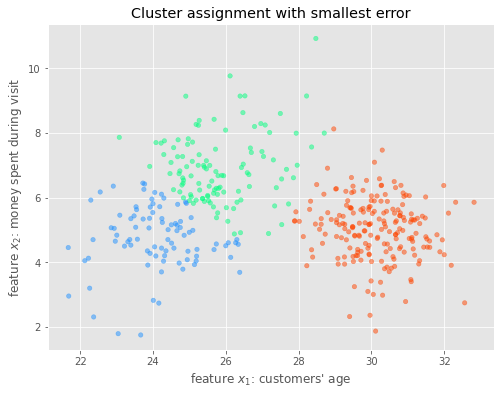

Cluster assignment with largest clustering error:


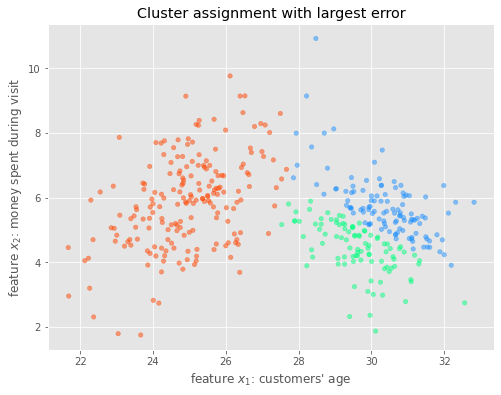

In [65]:

m = X.shape[0]  # Number of data points

min_ind = 0  # Store here the index of the repetition yielding smallest clustering error 
max_ind = 0  # .... largest clustering error

cluster_assignment = np.zeros((50, m), dtype=np.int32)  # Array for storing clustering assignments
clustering_err = np.zeros(50,)    # Array for storing the clustering errors for each assignment

np.random.seed(42)   # Set random seed for reproducibility (DO NOT CHANGE THIS!)

init_means_cluster1 = np.random.randn(50,2)  # Use the rows of this numpy array to init k-means 
init_means_cluster2 = np.random.randn(50,2)  # Use the rows of this numpy array to init k-means 
init_means_cluster3 = np.random.randn(50,2)  # Use the rows of this numpy array to init k-means 

best_assignment = np.zeros(m)     # Store here the cluster assignment achieving the smallest clustering error
worst_assignment = np.zeros(m)    # Store here the cluster assignment achieving the largest clustering error
'''
from sklearn.cluster import KMeans
m, n = X.shape    # Get the number of data points m and number of features n
k = 2    # The number of clusters to use

np.random.seed(1)    # Set random seed for reproducability (DO NOT CHANGE THIS!)

k = 3    # Define number of clusters to use

k_means = KMeans(n_clusters = k, max_iter = 100)  # Create k-means object with k=3 clusters and using maximum 100 iterations
k_means.fit(X)    # Fit the k-means object (find the cluster labels for the datapoints in X)
cluster_means = k_means.cluster_centers_    # Get cluster means (centers)
cluster_indices = k_means.labels_           # Get the cluster labels for each data point

### STUDENT TASK ###
# ...
k_means = KMeans(n_clusters = k, max_iter = 10)
k_means.fit(X)
cluster_means = k_means.cluster_centers_
cluster_indices = k_means.labels_   
# YOUR CODE HERE

# Plot the clustered data
plotting(X, cluster_means, cluster_indices, title='K-means clustering with $k=2$')

def plotting(data, centroids=None, clusters=None, title='Data', show=True):

print("The final cluster mean values are:\n", cluster_means)
'''

### STUDENT TASK ###
for r in range(50): 
    # loop 0,...,49
    init1 = init_means_cluster1[r, :]
    init2 = init_means_cluster2[r, :]
    init3 = init_means_cluster3[r, :]
    initMatrix = np.concatenate((init1, init2, init3)).reshape(3,2)
    k_means = KMeans(n_clusters = 3, init = initMatrix, max_iter = 10, n_init = 1)
    k_means.fit(X)
    cluster_assignment[r, :] = k_means.labels_
    clustering_err[r] = k_means.inertia_ / m

# end loop

print(cluster_assignment)
min_ind = np.where(clustering_err == np.amin(clustering_err))[0]
max_ind = np.where(clustering_err == np.amax(clustering_err))[0]
best_assignment = cluster_assignment[min_ind].reshape(-1)
worst_assignment = cluster_assignment[max_ind].reshape(-1)
print(best_assignment)
# YOUR CODE HERE

# Print the best and worst clustering errors
print(f"Best clustering error: {clustering_err[min_ind]}\n")
print(f"Worst clustering error: {clustering_err[max_ind]}\n")

# Plot the best and worst cluster assignments (w.r.t. clustering error)
plotting(X, clusters=best_assignment, title='Cluster assignment with smallest error')
print("Cluster assignment with largest clustering error:")
plotting(X, clusters=worst_assignment, title='Cluster assignment with largest error')

In [66]:
# Perform some sanity checks on the solution
assert any(best_assignment != 0), 'You have to assign value for best_assignment ' 
assert any(worst_assignment != 0), 'You have to assign value for worst_assignment ' 
assert best_assignment.shape[0] == 400, 'incorrect cluster labels for minimal clustering error'
assert worst_assignment.shape[0] == 400, 'incorrect cluster labels for maximal clustering error'

print('Sanity check tests passed!')

Sanity check tests passed!


In [67]:
# hidden test


In [68]:
# hidden test


If you have completed the task correctly, you should see plot similar to this one:

<img src="../../../coursedata/R5_Clustering/Repeat_kmeans.png" alt="Drawing" style="width: 600px;"/>

## How Many Clusters ? 

Sometimes it is not clear what a good choice for the number $k$ of clusters should be. One possible (data-driven) method to choose $k$ is to run k-means for increasing values of $k$ until the clustering error is below a prescribed level (say $10$ percent of the clustering error with $k=1$ clusters). 

How would you expect the error to behave with respect to the number of clusters? Do you think that the clustering error is a good selection criteria for the number of clusters?

<div class="alert alert-warning">

<b> Student Task.</b> Try out different number $k$ of clusters. 


Apply k-means to the Cafe customer data for the choices $k=1,\ldots,8$. For each choice of $k$, fit `KMeans` using $L=100$ iterations. Store the resulting clustering error in the numpy array `err_clustering` of shape (8,).  

    
**Hint:** The sum of the squared distances of the data points to their respective centers is stored in the attribute `KMeans.inertia_` after fitting the k-means model. This value can be used to calculate the clustering error with the formula in (3). 
</div>

Clustering errors: 
[9.5232033  2.92348141 2.02178865 1.65213431 1.37075191 1.19051541
 1.01402502 0.91623559]


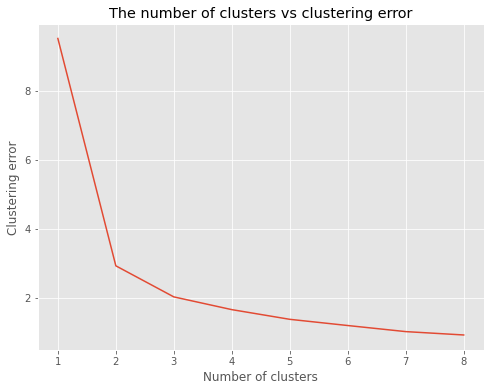

In [69]:
m = X.shape[0]    # Number of data points
err_clustering = np.zeros(8)    # Array for storing clustering errors

np.random.seed(1)  # Set random seed

### STUDENT TASK ###
# YOUR CODE HERE
for k in range (1,9):
    k_means = KMeans(n_clusters = k, max_iter = 100)
    k_means.fit(X)
    err_clustering[k-1] = k_means.inertia_ / m

print(f'Clustering errors: \n{err_clustering}')

# Plot the clustering error as a function of the number k of clusters
plt.figure(figsize=(8,6))
plt.plot(range(1,9), err_clustering)
plt.xlabel('Number of clusters')
plt.ylabel('Clustering error')
plt.title("The number of clusters vs clustering error")
plt.show()    

In [70]:
# Perform some sanity checks on the outputs
assert all(err_clustering > 0), 'Store clustering errors for varing number of clusters' 
assert err_clustering.shape == (8,), 'Incorrect shape for errors of models. Use the pre-defined variable err_clustering'

print('Sanity check tests passed!')


Sanity check tests passed!


If you have completed the task correctly, you should see plot similar to this one:

<img src="../../../coursedata/R5_Clustering/number_of_clusters.png" alt="Drawing" style="width: 600px;"/>

In the figure above, we can see that the clustering error decreases monotonously with an increasing number of clusters. This is expected since the addition of an additional cluster cannot result in a larger average distance from the points to their corresponding cluster means. It naturally follows that the raw clustering error is not a good measure for the selection of the number of clusters since it will always favor a larger number. 

The selection of a suitable number of clusters is a central part of solving clustering problems, and many techniques have been developed for this purpose. We do not consider this aspect of clustering problems in this course in more detail, but additional information can be found on, for example, [wikipedia](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set). 

# Soft Clustering 

The information provided by the cluster assignments $y^{(i)}$ delivered by $k$-means is relatively coarse-grained since it only defines whether or not a data point belongs to a cluster or not. Even if two data points belong to the same cluster, their location within the cluster might differ significantly. In the image below, the data points represented by blue dots that lie outside the largest circle are somewhat in-between different clusters. However, the cluster assignments obtained by k-means do not reflect the location of the data points relative to the cluster centers.

<center>
    <img src="../../../coursedata/R5_Clustering/graph_example.png" alt="Example of not good hard-clustering"/>
</center>

In many applications, it is useful to measure the confidence of a data point belonging to a cluster. For example, in our customer segmentation problem, we might want to measure the extent (or degree) to which a customer belongs to the various segments. This can be done using soft clustering methods that assign each data point $\mathbf{x}^{(i)}$ with a vector $\mathbf{y}^{(i)}= (y^{(i)}_1,...,y^{(i)}_k) \in [0,1]^k$, where the entry $y^{(i)}_c$ represents the degree of confidence that $\mathbf{x}^{(i)}$ belongs to the cluster $\mathcal{C}_c$.

When applying a **probabilistic model**, we interpret data points as realizations of random variables and fit a probability distribution to the data. For example, when applying a Gaussian model to a dataset, we assume that the data is Gaussian and fit a normal distribution to the data by finding the optimal values for the distribution's mean and variance.  The optimal values for the mean and variance are defined as the values that maximize the likelihood of observing the data, assuming that it is normally distributed. 

##  Clustering with Gaussian Mixture Models 

A principled approach to soft-clustering is based on interpreting data points $\mathbf{x}^{(i)}$ as realizations of a random vector $\mathbf{x}$ with the probability distribution $p(\mathbf{x})$. Soft-clustering assumes that each data point is obtained by randomly drawing from one of $k$ different probability distributions (representing clusters), with the probability of drawing the data point from the $c$:th distribution being $p_c$. The aim of soft clustering is to find the probability distributions and probabilities $p_c$ that best explain the observed data. After doing this, we can calculate the probabilities of each data point originating from each distribution, and assign it to the cluster with the highest probability.

In a **Gaussian Mixture Model (GMM)**, the data is assumed to be drawn from $k$ different [multivariate Gaussian distributions](https://en.wikipedia.org/wiki/Multivariate_normal_distribution), each parametrized by a mean vector $\mathbf{\mu}^{(c)}$ and a covariance matrix $\mathbf{C}^{(c)}$. Furthermore, the model has the parameters $p_c$ representing the probability of drawing a data point from the distribution $c$. The model is fitted by finding the parameters $\mu_c, \mathbf{C}_c, p_c$, for each $c=1,\ldots,k$ (where $k$ is the number of clusters), that maximize the likelihood of the observed data.

The theory behind the GMM is too advanced for this course and will not be considered in this notebook. Some more details are presented below, but a more comprehensive explanation is available for the interested in [this video](https://www.youtube.com/watch?v=qMTuMa86NzU).

### Fitting a GMM (optional material)

The probability density function (pdf) of a Gaussian random vector $\mathbf{x}$ with mean $\mu$ and covariance matrix $\mathbf{C}$ is given as 

\begin{equation}
\mathcal{N}(\mathbf{x} ; \mathbf{\mu}, \mathbf{C}) = \frac{1}{\sqrt{{\rm det} \big(2 \pi \mathbf{C}\big)}} {\rm exp } \bigg( -\frac{1}{2} \big(\mathbf{x} - \mathbf{\mu} \big)^{T} \mathbf{C}^{-1}  \big(\mathbf{x} - \mathbf{\mu}\big)\bigg).
\end{equation}

Note that this expression is only valid for Gaussian random vectors having a non-singular (invertible) covariance matrix $\mathbf{C}$. The resulting pdf of a data point is a **Gaussian mixture model (GMM)**  
\begin{equation}
p(\mathbf{x}) = \sum_{c=1}^{k} p_{c} \mathcal{N}(\mathbf{x};\mathbf{\mu}^{(c)},\mathbf{C}^{(c)}). 
\end{equation}
The coefficients $p_{c} \geq 0$ are required to satisfy $\sum_{c=1}^{k}p_c=1$ and represent the (prior) probability that a data point is drawn from the cluster $\mathcal{C}_{c}$. 

Note that the GMM $p(\mathbf{x})$ is parametrized by 

* the cluster probabilities $p_{1},p_{2}, ..., p_k$, 
* the cluster means $\mathbf{\mu}^{(1)},\mathbf{\mu}^{(2)},..., \mathbf{\mu}^{(k)}$ 
* and the covariance matrices $\mathbf{C}^{(1)},\mathbf{C}^{(2)},..., \mathbf{C}^{(k)}$.

Using the GMM $p(\mathbf{x})$, we can make the notion of a degree of belonging precise. In particular, we define the degree $y_{c}^{(i)}$ of a data point $\mathbf{x}^{(i)}$ belonging to cluster $\mathcal{C}_{c}$ as the (posterior) probability that $\mathbf{x}^{(i)}$ is generated (drawn) from the Gaussian distribution associated with $\mathcal{C}_{c}$:  

$$\mathbf{y}^{(i)}_c = \frac{p_{c} \mathcal{N}(\mathbf{x}^{(i)} ; \mathbf{\mu}^{(c)}, \mathbf{C}^{(c)})}{\sum_{c'=1}^k p_{c'} \mathcal{N}(\mathbf{x}^{(i)} ; \mathbf{\mu}^{(c')}, \mathbf{C}^{(c')})} $$

After determining the degrees of belonging $\mathbf{y}^{(i)}_c$, we can update our guess for (estimate of) the cluster probabilities $p_{c}$, cluster means $\mathbf{\mu}^{(c)}$ and covariance matrix $\mathbf{C}^{(c)}$.

In summary this algorithm consists of 4 steps:

* __Step 1 - Initialize the cluster parameters. These are the means and covariances for every cluster.__
* __Step 2 - Update the degree of data point $\mathbf{x}^{(i)}$ belonging to cluster c.__
* __Step 3 - Update cluster probabilities $p_{c}$, means $\mathbf{\mu}^{(c)}$ and covariances $\mathbf{C}^{(c)}$.__
* __Step 4 - If stopping criterion is not satisfied, go to step 2__

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Plotting a GMM. 

The code snippet below implements a helper-function `plot_GMM()` which can be used to illustrate GMM along with the scatterplot of data points. You do not need to understand the details, but feel free to explore it.

  </div>

In [71]:
def plot_GMM(data, means, covariances, k, clusters=None):
    
    ## Select three colors for the plot
    # if you want to plot curves k>3, extend these lists of colors
    data_colors = ['orangered', 'dodgerblue', 'springgreen'] # colors for data points
    centroid_colors = ['red', 'darkblue', 'limegreen'] # colors for the centroids
    
    k = means.shape[0]
    plt.figure(figsize=(8,6))    # Set figure size
    if clusters is None:
        plt.scatter(data[:,0], data[:,1], s=13, alpha=0.5)
    else:
        plt.scatter(data[:,0], data[:,1], c=[data_colors[i] for i in clusters], s=13, alpha=0.5)

    # Visualization of results
    x_plot = np.linspace(19, 35, 100)
    y_plot = np.linspace(0, 12, 100)
    x_mesh, y_mesh = np.meshgrid(x_plot, y_plot)
    pos = np.empty(x_mesh.shape + (2,))
    pos[:,:,0] = x_mesh 
    pos[:,:,1] = y_mesh

    # For each cluster, plot the pdf defined by the mean and covariance
    for i in range(k):
        z = multivariate_normal.pdf(pos, mean = means[i,:], cov = covariances[i])
        plt.contour(x_mesh, y_mesh, z, 4, colors=centroid_colors[i], alpha=0.5)
        plt.scatter(means[i,0], means[i,1], marker='x', c=centroid_colors[i])

    plt.title("Soft clustering with GMM")
    plt.xlabel("feature x_1: customers' age")
    plt.ylabel("feature x_2: money spent during visit")
    plt.show()

<a id='handsondata'></a>
<div class=" alert alert-warning">
    <b>Student task.</b> Soft clustering using GMM. 

Your task is to perform soft clustering on the customer data using a GMM model with `k=3` clusters. Here, `k` is a model hyperparameter that is given as an argument when creating the `GaussianMixture` instance. The means of the components of the fitted GMM should be stored in the variable `means`, the covariance matrices in `covariances`, and the cluster labels (or indices) in `cluster_labels`.

After fitting the `GaussianMixture` object, the means can be found in the `.means_` attribute and the covariances in the `.covariances_` attribute.
    
The final result of the clustering will be plotted below.
</div>

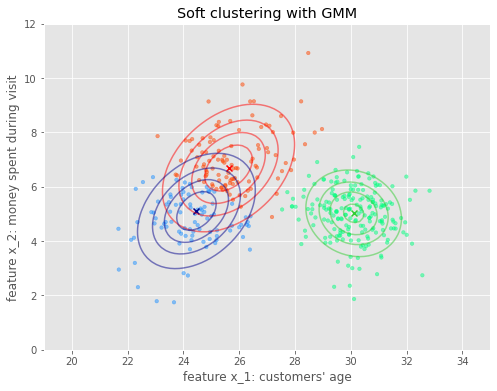

The means are:
 [[25.6154086   6.6874243 ]
 [24.46484646  5.10831508]
 [30.09938306  5.02145697]] 

The covariance matrices are:
 [[[ 1.75539668  0.64515293]
  [ 0.64515293  1.72661107]]

 [[ 1.42319654  0.51707087]
  [ 0.51707087  1.43739154]]

 [[ 1.00676569 -0.1164302 ]
  [-0.1164302   0.87158468]]]


In [72]:
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal # Multivariate normal random variable

m, n = X.shape

# Define the number of clusters
k = 3

np.random.seed(1)    # Set random seed for reproducability 

### STUDENT TASK ###
gmm = GaussianMixture(n_components = k)
gmm.fit(X)
cluster_labels = gmm.predict(X)
means = gmm.means_
covariances = gmm.covariances_
# YOUR CODE HERE

plot_GMM(X, means, covariances, k, cluster_labels)
print("The means are:\n", means, "\n")
print("The covariance matrices are:\n", covariances)

In [73]:
# Perform some sanity check on the outputs
assert means.shape == (3, 2), "The shape of 'means' is wrong!"
assert covariances.shape == (3, 2, 2), "The shape of 'covariances' is wrong!"
assert cluster_labels.shape == (X.shape[0],)

print('Sanity checks passed')

Sanity checks passed


In [74]:
# hidden test


In [75]:
# hidden test


In [76]:
# hidden test


From the figure, we can see that the red cluster seems quite distinct from the other datapoints. In contrast, the blue and green clusters seem to have considerable overlap. 

# Density Based Clustering

Both k-means and GMM cluster data points using the Euclidean distance, which is a natural measure of similarity in many cases. However, in some applications, the data conforms to a different non-Euclidean structure. 

One important non-Euclidean structure is based on the notion of connectivity. Here, two data points are considered similar if they can be reached by intermediate data points that have a small Euclidean distance. Thus, two data points can be similar in terms of connectivity, even if their Euclidean distance is large.

<img src="../../../coursedata/R5_Clustering/DBSCAN.png" alt="Drawing" style="width: 500px"/>


**Density-based spatial clustering of applications with noise (DBSCAN)** is a hard clustering method that uses a connectivity-based similarity measure. In contrast to k-means and the GMM, DBSCAN does not require the number of clusters to be pre-defined -  the number will depend on its parameters. Moreover, DBSCAN detects outliers that are interpreted as degenerated clusters consisting of a single data point. For a detailed discussion of how DBSCAN works, we refer to https://en.wikipedia.org/wiki/DBSCAN.  

<img src="../../../coursedata/R5_Clustering/DBSCAN_tutorial.gif" alt="Drawing" style="width: 450px;"/>

DBSCAN is implemented in the `DBSCAN` class in scikit-learn [Documentation can be found here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). DBSCAN requires specifying two parameters  `eps` and `min_samples`. The meaning of these parameter are well explained [here](https://scikit-learn.org/stable/modules/clustering.html#dbscan). 
The DBSCAN implementation `fit_predict(self, X[, y, sample_weight])` returns cluster labels.

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Generating two datasets with different structures. 

The code snippet below creates two datasets $\mathbb{X}^{(1)}$ and $\mathbb{X}^{(2)}$ with different structures, which will be used to present the usefulness of DBSCAN. The datasets are stored in the numpy arrays `dataset1` and `dataset2` respectively.

</div>

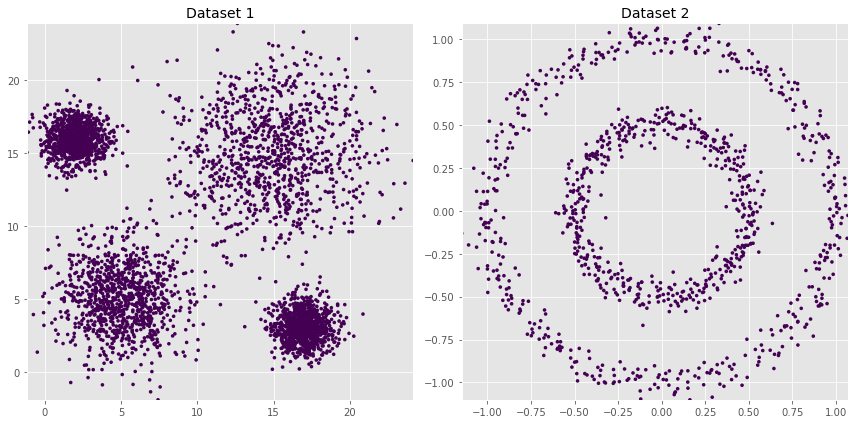

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph

np.random.seed(844)    # Set random seed for reproducibility

# Create dataset with separate Gaussian clusters
clust1 = np.random.normal(5, 2, (1000,2))
clust2 = np.random.normal(15, 3, (1000,2))
clust3 = np.random.multivariate_normal([17,3], [[1,0],[0,1]], 1000)
clust4 = np.random.multivariate_normal([2,16], [[1,0],[0,1]], 1000)
dataset1 = np.concatenate((clust1, clust2, clust3, clust4))

# Create dataset containing circular data
dataset2 = datasets.make_circles(n_samples=1000, factor=.5, noise=.05)[0]

# Function for plotting clustering output on two datasets
def cluster_plots(data_1, data_2, clusters_1, clusters_2, title1='Dataset 1',  title2='Dataset 2'):
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].set_title(title1,fontsize=14)
    ax[0].set_xlim(min(data_1[:,0]), max(data_1[:,0]))
    ax[0].set_ylim(min(data_1[:,1]), max(data_1[:,1]))
    ax[0].scatter(data_1[:,0], data_1[:,1], s=13, lw=0, c=clusters_1)
    ax[1].set_title(title2,fontsize=14)
    ax[1].set_xlim(min(data_2[:,0]), max(data_2[:,0]))
    ax[1].set_ylim(min(data_2[:,1]), max(data_2[:,1]))
    ax[1].scatter(data_2[:,0], data_2[:,1], s=13, lw=0, c=clusters_2)
    fig.tight_layout()
    plt.show()

# Plot the unclustered datasets (i.e. all points belonging to cluster 1)
cluster_plots(dataset1, dataset2, np.ones(dataset1.shape[0]), np.ones(dataset2.shape[0]))

While the first dataset consists of clusters in the Euclidean sense, the structure of the second dataset is different. Visually, it seems clear that there are two clusters corresponding to the data in the inner and outer ring respectively. Let us apply k-means to both datasets and evaluate whether the resulting clusterings match our intuitive ones.

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Demo.</b> K-means on Euclidean and non-Euclidean clusters. 

The code snippet below uses k-means to cluster the data `dataset1` and `dataset2`, and plots the resulting clusterings for evaluation of the results.

</div>

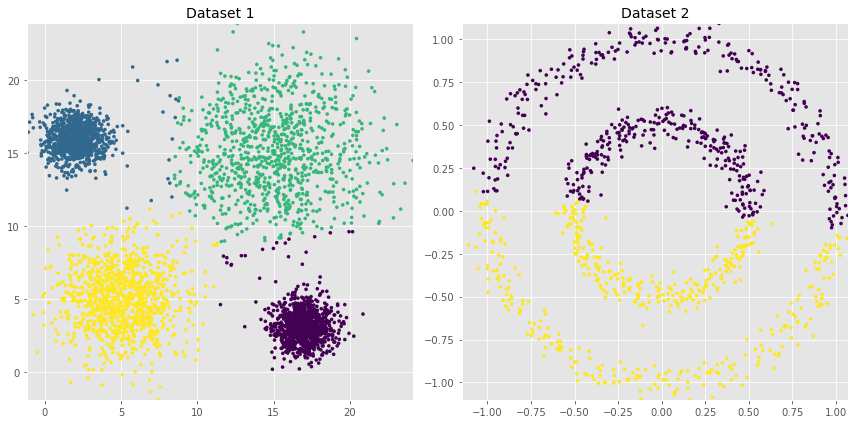

In [78]:
from sklearn.cluster import KMeans

# Perform k-means clustering on both datasets, and get the clusters for each datapoint
k_means_1 = KMeans(n_clusters=4)
k_means_2 = KMeans(n_clusters=2)
clusters_1 = k_means_1.fit_predict(dataset1)
clusters_2 = k_means_2.fit_predict(dataset2)

# Plot the clustered datasets
cluster_plots(dataset1, dataset2, clusters_1, clusters_2)

The shortcomings of k-means when applied to the circular data are apparent in the figure above. While k-means produces a reasonable clustering of the first dataset $\mathbb{X}^{(1)}$, it fails to find the intrinsic cluster structure of the second dataset $\mathbb{X}^{(2)}$. Next, you will apply DBSCAN to the same datasets and in particular explore whether this method results in a better clustering for the second dataset.

<div class="alert alert-warning">

<b> Student Task.</b> Clustering with DBSCAN. 

Apply DBSCAN to the two datasets $\mathbb{X}^{(1)}$ and $\mathbb{X}^{(2)}$ stored in the numpy arrays `dataset1` and `dataset2`.
Use the parameter choices `min_samples=5`, `metric='euclidean'` and `eps` value $1$ for $\mathbb{X}^{(1)}$ and value $0.1$ for dataset $\mathbb{X}^{(2)}$. 
Use the `fit_predict(dataset)` method to obtain the cluster assignments for the data points in each of the two data sets and store them in the numpy arrays `clusters_1` and `clusters_2`, respectively. 

* `clusters_1` should be of shape $(4000, )$

* `clusters_2` should be of shape $(1000, )$

* for each dataset, count the number of data points that do not belong to any cluster and Store them in the variables `dataset1_noise_points` and `dataset2_noise_points`. The assigned cluster label for these data points is `-1`. 


</div>

(4000,)
[0 0 0 ... 3 3 3]
(1000,)
(4000, 2)
(1000, 2)
Noise points in Dataset 1:
 47/4000 

Noise points in Dataset 2:
 2/1000 



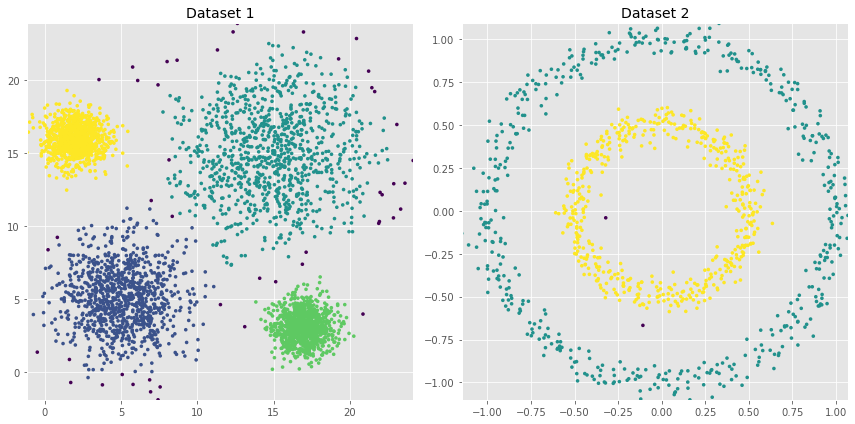

In [79]:
from sklearn.cluster import DBSCAN

# Define eps values for the two datasets
eps_1 = 1
eps_2 = 0.1

### STUDENT TASK ###
clusters_1 = DBSCAN(eps = eps_1, min_samples=5, metric='euclidean').fit_predict(dataset1)
clusters_2 = DBSCAN(eps = eps_2, min_samples=5, metric='euclidean').fit_predict(dataset2)
print(clusters_1.shape)
print(clusters_1)
print(clusters_2.shape)
print(dataset1.shape)
print(dataset2.shape)
dataset1_noise_points = sum(map(lambda x : x == -1, clusters_1))
dataset2_noise_points = sum(map(lambda x : x == -1, clusters_2))
# YOUR CODE HERE


print(f'Noise points in Dataset 1:\n {dataset1_noise_points}/{len(clusters_1)} \n')
print(f'Noise points in Dataset 2:\n {dataset2_noise_points}/{len(clusters_2)} \n')

# Plot the clustered datasets
cluster_plots(dataset1, dataset2, clusters_1, clusters_2)

In [80]:
# Perform some sanity checks on the outputs
assert clusters_1.shape == (4000,), 'Shape of clusters_1 is wrong.'
assert clusters_2.shape == (1000,), 'Shape of clusters_2 is wrong.'
assert dataset1_noise_points < 50, 'Number of noise points in dataset 1 should be less than 50.'
assert dataset2_noise_points < 5, 'Number of noise points in dataset 2 should be less than 5.'

print('Sanity check tests passed!')

Sanity check tests passed!


In [81]:
# hidden test


In [82]:
# hidden test


If you solved the exercise correctly, it should be evident that DBSCAN performs significantly better on the second dataset compared to the k-means algorithm. We can also observe that some of the datapoints in both datasets are left unclustered. 

## Combining Clustering with Logistic Regression

Assume that we have found different customer segments in the customer dataset using clustering. Now, we would like to provide each new customer targeted offers on our products based on the segment that the customer belongs to. This means that we would have to classify each new customer into one of the customer segments.

A simple approach to this is to use some classification criteria based on the clustering algorithm used. For example, if we used k-means for clustering we could assign each new customer to the class whose mean is closest to the new data point. A more refined approach is to first use some algorithm to find a reasonable clustering for the dataset, and then train a separate classifier (e.g. logistic regression) on the clustered data, using the cluster assignments as the labels of the data points.

<a id='clusterregression'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Combining clustering with logistic regression. 

The code snippet below demonstrates how to use clustering in conjunction with logistic regression to classify new customers into one of the customer segments found by clustering. In this example we use k-means for clustering and logistic regression for classification, but these could be replaced by alternative clustering and classification algorithms. The process consists of the following steps:
    
- Choose the number $k$ of presumed clusters in the dataset and use k-means to cluster the data
    
    
- Define a supervised classification problem with feature matrix $\mathbf{X}$ and label vector $y$, which contains the labels obtained by clustering
    
    
- Use logistic regression to find the decision boundaries between the k classes (previously clusters).
    
</div>

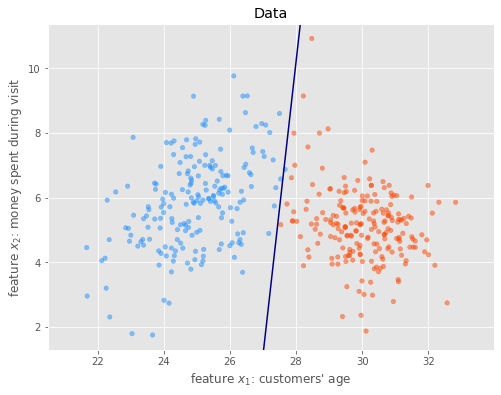

In [83]:
from sklearn.linear_model import LogisticRegression

np.random.seed(42)    # Set random seed for reproducibility

k = 2    # Select the number of clusters  
k_means = KMeans(n_clusters=k)
k_means.fit(X)
y = k_means.labels_    # Define the label vector y as the cluster labels

# Fit logistic regression model 
log_reg = LogisticRegression()
log_reg.fit(X, y)

# Get the weights and intercept of the decision boundary for plotting
w = log_reg.coef_
intercept = log_reg.intercept_

# Plot clusters and decision boundary
plotting(X, clusters=y, show=False)
ax = plt.gca()    # Get current axes 
x_min, x_max = ax.get_xlim()  # Get x-axis limits from axes
x_g = np.linspace(x_min, x_max)  # Define values w.r.t. which to plot predictors
decision_boundary = (-intercept - w[:,0] * x_g) / w[:,1]  # Calculate decision boundary w.r.t. x_1
y_lim = ax.get_ylim() 
plt.plot(x_g, decision_boundary, color='navy')  # Plot decision boundary
plt.ylim(y_lim)
plt.show()

We can see that the linear decision boundary nicely separates the two customer segments. Given a dataset contain data on new customers, we could now use the logistic regression model to classify these customers into one of the two segments.

There is one significant caveat that must be taken into account when using combining clustering with classification in the way that is described here. The labels of classification problems are in general guaranteed to be accurate (up to human judgement) since the data points are labelled manually. However, when using clustering to obtain the labels there is no similar guarantee that the labels are reasonable or that the classes actually represent something meaningful. One should thus strive to validate  the reasonability of the clustering if possible.

## Quiz questions

<a id='QuestionR5_1'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> Question R5.1. </p>

 <p>Which of the following statements is true?</p>

<ol>
  <li> Clustering methods require labeled data points.</li>
  <li> Clustering methods aim at predicting a numeric quantity.</li>
  <li> Clustering methods do not require any labeled data.</li>
  <li> Clustering methods can only be used for less than 500 data points.</li>
</ol> 

</div>

In [84]:
### STUDENT TASK ###
# remove the line raise NotImplementedError() before testing your solution and submitting code
answer_R5_Q1 = 3

# YOUR CODE HERE

In [85]:
# This cell is for tests

assert answer_R5_Q1 in [1,2,3,4], '"answer_R5_Q1" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')


Sanity check tests passed!


<a id='QuestionR5_2'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> Question R5.2. </p>

 <p>Which of the following statements is true?</p>

<ol>
  <li> DBSCAN is a soft clustering method.</li>
  <li> DBSCAN automatically determines the number of clusters.</li>
  <li> DBSCAN requires labeled data.</li>
  <li> DBSCAN can only be used for less than $1000$ data points.</li>
</ol> 

</div>

In [86]:
### STUDENT TASK ###
# remove the line raise NotImplementedError() before testing your solution and submitting code
answer_R5_Q2 = 2

# YOUR CODE HERE


In [87]:
# This cell is for tests

assert answer_R5_Q2 in [1,2,3,4], '"answer_R5_Q2" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')


Sanity check tests passed!


<a id='QuestionR5_4'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> Question R5.3. </p>

 <p>In which of the following ways is clustering combined with classification in this notebook?</p>

<ol>
  <li> Clustering is used to separate the training and validation sets used for classification </li>
  <li> Clustering is used to find clusters within different classes </li>
  <li> Clustering is used to give a label for each datapoint, after which a supervised classification algorithm is trained on the labelled data.</li>
  <li> Classification is used to validate the reasonability of the clustering</li>
</ol> 

</div>

In [88]:
### STUDENT TASK ###
# remove the line raise NotImplementedError() before testing your solution and submitting code
answer_R5_Q3 = 3

# YOUR CODE HERE


In [89]:
# This cell is for tests

assert answer_R5_Q3 in [1,2,3,4], '"answer_R5_Q3" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')


Sanity check tests passed!
